# 데이터 전처리

## 라이브러리 import

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os, random, time, gc, warnings

from tqdm import tqdm_notebook

import lightgbm as lgbm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import RFECV


from sklearn.cluster import KMeans

from datetime import datetime

from math import sqrt

warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

%matplotlib inline

## 데이터 전처리

In [14]:
df=pd.read_csv('D:\\test2\\data-04.02.csv')
print(df.shape)
df.head()

(625, 13)


,index,uid,completed,cycle,m1in,m1process,m1out,m2in,m2process,m2out,m3in,m3process,m3out
0,1,c37ba1af,1,1,14:04:51,1.40,0:00:00,14:03:35,1.85,14:06:15,14:06:26,2.87,14:06:51
1,2,c37ba1af,1,1,0:00:00,0.51,14:08:51,14:08:53,5.41,14:09:16,14:09:20,5.70,14:09:26
2,3,c37ba1af,1,1,14:10:02,1.76,14:13:02,14:13:04,0.59,14:16:30,14:16:40,0.08,14:16:47
3,4,c37ba1af,0,1,14:36:28,5.23,14:38:19,14:38:21,5.91,14:38:58,0:00:00,1.79,0:00:00
4,5,c37ba1af,0,1,0:00:00,1.74,0:00:00,0:00:00,3.78,0:00:00,0:00:00,0.28,0:00:00


In [20]:
#오름차순으로 정렬
df.sort_values(by=['m1in'], axis=0, ascending=True)

,index,uid,completed,cycle,m1in,m1process,m1out,m2in,m2process,m2out,m3in,m3process,m3out
312,313,c37b83cb,0,3,0:00:00,3.41,0:00:00,0:00:00,1.97,0:00:00,0:00:00,1.96,0:00:00
395,396,c37ba1b6,0,4,0:00:00,3.48,0:00:00,0:00:00,15.89,0:00:00,0:00:00,0.37,0:00:00
396,397,c37ba1b6,0,4,0:00:00,0.81,0:00:00,0:00:00,8.04,0:00:00,0:00:00,3.19,0:00:00
397,398,c37ba1b6,0,4,0:00:00,6.71,0:00:00,0:00:00,0.70,0:00:00,0:00:00,1.51,0:00:00
398,399,c37ba1b6,0,4,0:00:00,1.38,0:00:00,0:00:00,4.08,0:00:00,0:00:00,0.26,0:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,130,c37b9118,0,2,14:36:52,7.29,14:38:42,14:38:35,3.50,14:39:42,0:00:00,5.88,0:00:00
405,406,c37b9987,0,4,14:37:54,3.32,14:39:03,0:00:00,3.04,0:00:00,0:00:00,17.16,0:00:00
352,353,c37ba2e1,0,3,14:38:23,5.45,14:37:11,14:33:09,4.88,14:30:04,0:00:00,2.05,0:00:00
429,430,c37b81a9,0,4,14:38:45,3.18,14:37:32,14:37:35,8.57,14:40:31,14:37:58,1.58,0:00:00


In [35]:
# 시간이 하나도 찍히지 않은 제품 식별 후 삭제
df_idx_1 = df[(df['m1in'] == '0:00:00') & (df['m1out'] == '0:00:00') & (df['m2in'] == '0:00:00') & (df['m2out'] == '0:00:00') & (df['m3in'] == '0:00:00') & (df['m3out'] == '0:00:00')].index
# len(df_idx)
df_sample_1 = df.drop(df_idx_1)
len(df_sample_1)

115

In [36]:
df_sample_1.describe()

,index,completed,cycle,m1process,m2process,m3process
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,306.991304,0.782609,3.026087,3.696957,3.852174,3.594870
std,178.874772,0.414276,1.435520,3.251464,3.665876,3.372838
min,1.000000,0.000000,1.000000,0.020000,0.040000,0.010000
25%,140.500000,1.000000,2.000000,1.055000,1.025000,1.275000
50%,326.000000,1.000000,3.000000,3.030000,2.700000,2.600000
75%,465.000000,1.000000,4.000000,5.325000,5.860000,5.065000
max,604.000000,1.000000,5.000000,15.210000,16.540000,17.160000


In [37]:
df_sample_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 603
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      115 non-null    int64  
 1   uid        115 non-null    object 
 2   completed  115 non-null    int64  
 3   cycle      115 non-null    int64  
 4   m1in       115 non-null    object 
 5   m1process  115 non-null    float64
 6   m1out      115 non-null    object 
 7   m2in       115 non-null    object 
 8   m2process  115 non-null    float64
 9   m2out      115 non-null    object 
 10  m3in       115 non-null    object 
 11  m3process  115 non-null    float64
 12  m3out      115 non-null    object 
dtypes: float64(3), int64(3), object(7)
memory usage: 12.6+ KB


In [40]:
# m1in & m1out 둘 다 찍힌 인덱스
df_idx_2 = df[(df['m1in'] != '0:00:00') & (df['m1out'] != '0:00:00')].index
# m1out & m2in 둘 다 찍힌 인덱스
df_idx_3 = df[(df['m1out'] != '0:00:00') & (df['m2in'] != '0:00:00')].index
# m2in & m2out 둘 다 찍힌 인덱스
df_idx_4 = df[(df['m2in'] != '0:00:00') & (df['m2out'] != '0:00:00')].index
# m2out & m3in 둘 다 찍힌 인덱스
df_idx_5 = df[(df['m2out'] != '0:00:00') & (df['m3in'] != '0:00:00')].index
# m3in & m3out 둘 다 찍힌 인덱스
df_idx_6 = df[(df['m3in'] != '0:00:00') & (df['m3out'] != '0:00:00')].index

print(len(df_idx_2),len(df_idx_3),len(df_idx_4),len(df_idx_5),len(df_idx_6))

71 82 93 88 90


In [56]:
df_sample_2 = df.loc[df_idx_2]
df_sample_2['m1in'] = pd.to_datetime(df_sample_2['m1in'], format="%H:%M:%S")
df_sample_2['m1out'] = pd.to_datetime(df_sample_2['m1out'], format="%H:%M:%S")
df_sample_2['diffrence_1'] = df_sample_2['m1out'] - df_sample_2['m1in']
df_sample_2['diffrence_1'].describe()

count                           71
mean     0 days 00:02:39.732394366
std      0 days 00:03:15.900919398
min              -1 days +23:56:25
25%                0 days 00:00:07
50%                0 days 00:01:51
75%         0 days 00:04:30.500000
max                0 days 00:11:23
Name: diffrence_1, dtype: object

In [15]:
df.describe()

,index,completed,cycle,m1process,m2process,m3process
count,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000
mean,313.000000,0.144000,3.000000,3.877008,3.778912,3.883728
std,180.566239,0.351371,1.415346,3.669059,3.835456,3.950821
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.010000
25%,157.000000,0.000000,2.000000,1.210000,1.030000,1.080000
50%,313.000000,0.000000,3.000000,2.800000,2.610000,2.600000
75%,469.000000,0.000000,4.000000,5.410000,5.310000,5.530000
max,625.000000,1.000000,5.000000,24.140000,27.250000,25.240000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      625 non-null    int64  
 1   uid        625 non-null    object 
 2   completed  625 non-null    int64  
 3   cycle      625 non-null    int64  
 4   m1in       625 non-null    object 
 5   m1process  625 non-null    float64
 6   m1out      625 non-null    object 
 7   m2in       625 non-null    object 
 8   m2process  625 non-null    float64
 9   m2out      625 non-null    object 
 10  m3in       625 non-null    object 
 11  m3process  625 non-null    float64
 12  m3out      625 non-null    object 
dtypes: float64(3), int64(3), object(7)
memory usage: 63.6+ KB


In [17]:
n=df.isnull().sum()
n

index        0
uid          0
completed    0
cycle        0
m1in         0
m1process    0
m1out        0
m2in         0
m2process    0
m2out        0
m3in         0
m3process    0
m3out        0
dtype: int64

In [18]:
drop_column=['index', '0:00:37']
df_dropped=df.drop(drop_column, axis=1, inplace=False)

KeyError: "['0:00:37'] not found in axis"

In [63]:
df_dropped.head()

,m1buffer,m1~m2,m2buffer,m2~m3,m3buffer,cycletime
0,2,3,8,5,4,0:13:34
1,1,2,6,3,2,0:08:38
2,1,4,5,3,5,0:11:06
3,2,4,5,7,5,0:14:11
4,1,4,5,8,2,0:12:20


In [64]:
#sns.lineplot(data=df_dropped, x="MCOut1", y="MCOut3")

In [65]:
#문자열을 datetime 타입으로 변경
#dateval1 = time.strptime("25-01-2013 00:00:03:238", "%d-%m-%Y %H:%M:%S:%f")
#df_dropped['MCIn1'] = pd.to_datetime(df_dropped['MCIn1'], format="%H:%M")
#df_dropped['MCOut1'] = pd.to_datetime(df_dropped['MCOut1'], format="%H:%M")
#df_dropped['MCln2'] = pd.to_datetime(df_dropped['MCln2'], format="%H:%M")
#df_dropped['MCOut2'] = pd.to_datetime(df_dropped['MCOut2'], format="%H:%M")
#df_dropped['MCIn3'] = pd.to_datetime(df_dropped['MCIn3'], format="%H:%M")
df_dropped['cycletime'] = pd.to_datetime(df_dropped['cycletime'], format="%H:%M:%S")

In [66]:
#df_dropped_NotCompleted = df_dropped[df_dropped['completed'] == 0]

In [67]:
#df_dropped_NotCompleted

In [68]:
# 로그 데이터를 이용해 공정 내 제품 위치를 파악할 수 있는 로직 구현
# M1Buffer, M1~M2Conveyor, M2Buffer, M2~M3Conveyor, M3Buffer, (M3~M1Conveyor)

In [69]:
# index 38번째 들어오는 제품의 M3Out3 시간 기록
# 이것이 target variable

In [57]:
# 제품 위치 파악 => 그 다음 들어오는 제품의 M3Out 시간
# 이것이 한개의 데이터 셋
df.head()

,index,uid,completed,cycle,m1in,m1process,m1out,m2in,m2process,m2out,m3in,m3process,m3out
0,1,c37ba1af,1,1,14:04:51,1.40,0:00:00,14:03:35,1.85,14:06:15,14:06:26,2.87,14:06:51
1,2,c37ba1af,1,1,0:00:00,0.51,14:08:51,14:08:53,5.41,14:09:16,14:09:20,5.70,14:09:26
2,3,c37ba1af,1,1,14:10:02,1.76,14:13:02,14:13:04,0.59,14:16:30,14:16:40,0.08,14:16:47
3,4,c37ba1af,0,1,14:36:28,5.23,14:38:19,14:38:21,5.91,14:38:58,0:00:00,1.79,0:00:00
4,5,c37ba1af,0,1,0:00:00,1.74,0:00:00,0:00:00,3.78,0:00:00,0:00:00,0.28,0:00:00


In [79]:
df_test_1 = df.copy()
df_test_1['m1in'] = pd.to_datetime(df['m1in'], format="%H:%M:%S")
df_test_1

,index,uid,completed,cycle,m1in,m1process,m1out,m2in,m2process,m2out,m3in,m3process,m3out
0,1,c37ba1af,1,1,1900-01-01 14:04:51,1.40,0:00:00,14:03:35,1.85,14:06:15,14:06:26,2.87,14:06:51
1,2,c37ba1af,1,1,1900-01-01 00:00:00,0.51,14:08:51,14:08:53,5.41,14:09:16,14:09:20,5.70,14:09:26
2,3,c37ba1af,1,1,1900-01-01 14:10:02,1.76,14:13:02,14:13:04,0.59,14:16:30,14:16:40,0.08,14:16:47
3,4,c37ba1af,0,1,1900-01-01 14:36:28,5.23,14:38:19,14:38:21,5.91,14:38:58,0:00:00,1.79,0:00:00
4,5,c37ba1af,0,1,1900-01-01 00:00:00,1.74,0:00:00,0:00:00,3.78,0:00:00,0:00:00,0.28,0:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,621,c37b877b,0,5,1900-01-01 00:00:00,3.55,0:00:00,0:00:00,2.61,0:00:00,0:00:00,2.39,0:00:00
621,622,c37b877b,0,5,1900-01-01 00:00:00,1.25,0:00:00,0:00:00,1.62,0:00:00,0:00:00,14.40,0:00:00
622,623,c37b877b,0,5,1900-01-01 00:00:00,0.26,0:00:00,0:00:00,3.19,0:00:00,0:00:00,11.52,0:00:00
623,624,c37b877b,0,5,1900-01-01 00:00:00,24.14,0:00:00,0:00:00,1.49,0:00:00,0:00:00,4.21,0:00:00


In [84]:
#timeData_1 = ["14:05:00"]
#timeData_2 = pd.to_datetime(timeData_1, format="%H:%M:%S")

##m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0
#for i in df['index']:
#    if (timeData_2 >= df_test_1.loc[[i-1],['m1in']]) & (timeData_2 <= df_test_1.loc[[i-1],['m1out']]):
#        m1_buffer +=1
#    elif timeData >= df_test_1['m1out'] & timeData <= df_test_1['m2in']:
#        m1m2 +=1
#    elif timeData >= df_test_1['m2in'] & timeData <= df_test_1['m2out']:
#        m2buffer +=1
#    elif timeData >= df_test_1['m2out'] & timeData <= df_test_1['m3in']:
#        m2m3 +=1
#    elif timeData >= df_test_1['m3in'] & timeData <= df_test_1['m3out']:
#        m3buffer +=1

In [85]:
df_2=pd.read_csv('D:\\test2\\data-test-04.02.csv')
df_2.head()

,id,Uid,completed,CycleNumber,MCIn1,MC1PrTime,MCOut1,MCIn2,MC2PrTime,MCOut2,MCIn3,MC3PrTime,MCOut3
0,476,c37b7a6e,1,4,50512.09869,2.30,50593.00003,50597.00001,8.76,50602.99997,50614.99998,0.44,50617.99996
1,76,c37b7970,1,1,50537.62869,0.80,50594.35591,50597.14413,3.32,50610.00001,50621.00003,3.36,50625.99999
2,201,c37b8060,1,2,50553.74280,2.64,50598.99999,50600.99998,8.26,50622.00002,50632.00004,1.32,50634.00003
3,151,c37b736a,1,2,50583.00001,3.09,50611.75588,50614.99998,4.96,50654.99998,50669.99997,0.26,50674.00003
4,126,c37b9118,1,2,50589.74274,2.27,50619.88591,50624.00001,8.92,50675.00003,50687.00004,0.61,50688.00003


In [86]:
df_2.describe()

,id,completed,CycleNumber,MCIn1,MC1PrTime,MCOut1,MCIn2,MC2PrTime,MCOut2,MCIn3,MC3PrTime,MCOut3
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,306.991304,0.782609,3.026087,51567.704249,3.696957,51692.363761,51653.220161,3.852174,51740.243719,51756.855441,3.594870,51822.545220
std,178.874772,0.414276,1.435520,709.939758,3.251464,709.353124,694.460302,3.665876,706.067334,700.640590,3.372838,728.344248
min,1.000000,0.000000,1.000000,50512.098690,0.020000,50593.000030,50597.000010,0.040000,50602.999970,50614.999980,0.010000,50617.999960
25%,140.500000,1.000000,2.000000,50880.871390,1.055000,51142.500015,51154.499980,1.025000,51168.500025,51181.000030,1.275000,51186.499990
50%,326.000000,1.000000,3.000000,51534.999960,3.030000,51546.999970,51540.000020,2.700000,51647.000030,51721.999980,2.600000,51774.999980
75%,465.000000,1.000000,4.000000,52191.499995,5.325000,52424.000020,52296.999970,5.860000,52413.000005,52359.500005,5.065000,52505.000020
max,604.000000,1.000000,5.000000,52766.000040,15.210000,52780.000030,52788.124130,16.540000,52841.999980,52859.071360,17.160000,52907.084350


In [88]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           115 non-null    int64  
 1   Uid          115 non-null    object 
 2   completed    115 non-null    int64  
 3   CycleNumber  115 non-null    int64  
 4   MCIn1        115 non-null    float64
 5   MC1PrTime    115 non-null    float64
 6   MCOut1       115 non-null    float64
 7   MCIn2        115 non-null    float64
 8   MC2PrTime    115 non-null    float64
 9   MCOut2       115 non-null    float64
 10  MCIn3        115 non-null    float64
 11  MC3PrTime    115 non-null    float64
 12  MCOut3       115 non-null    float64
dtypes: float64(9), int64(3), object(1)
memory usage: 11.8+ KB


In [121]:
list1 = []
for i in range(50511,52907 + 1): #m1in min 시간과 m3out max 시간
    list1.append(i)
len(list1)

2397

In [122]:
# 데이터 받고 돌려볼 로직
#12시31분 -> 12시50분
#timeData = 51534
#m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0

list2=[]

m1_buffer_list =[]
m1m2_list =[]
m2buffer_list =[]
m2m3_list =[]
m3buffer_list =[]
ct_list=[]

for timeData in list1:
    m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0
    ct_idx=0
    ct=0
    for i, j in enumerate(df_2['id']):
        if (timeData >= df_2.loc[[i],['MCIn1']]).bool() & (timeData <= df_2.loc[[i],['MCOut1']]).bool():
            m1_buffer +=1
            ct_idx=i
        elif (timeData >= df_2.loc[[i],['MCOut1']]).bool() & (timeData <= df_2.loc[[i],['MCIn2']]).bool():
            m1m2 +=1
            ct_idx=i
        elif (timeData >= df_2.loc[[i],['MCIn2']]).bool() & (timeData <= df_2.loc[[i],['MCOut2']]).bool():
            m2buffer +=1
            ct_idx=i
        elif (timeData >= df_2.loc[[i],['MCOut2']]).bool() & (timeData <= df_2.loc[[i],['MCIn3']]).bool():
            m2m3 +=1
            ct_idx=i
        elif (timeData >= df_2.loc[[i],['MCIn3']]).bool() & (timeData <= df_2.loc[[i],['MCOut3']]).bool():
            m3buffer +=1
            ct_idx=i
    
    ct = df_2.loc[[ct_idx],['MCOut3']] - df_2.loc[[ct_idx],['MCIn1']]
    
    m1_buffer_list.apppend(m1_buffer)
    m1m2_list.append(m1m2)
    m2buffer_list.append(m2buffer)
    m2m3_list.append(m2m3)
    m3buffer_list.append(m3buffer)
    ct_list.append(ct)
    
df_3 = pd.DataFrame({'m1_buffer':m1_buffer_list,
                     'm1m2':m1m2_list,
                     'm2buffer':m2buffer_list,
                     'm2m3':m2m3_list,
                     'm3buffer':m3buffer_list,
                     'CycleTime':ct_list})

In [123]:
#print(m1_buffer , m1m2, m2buffer, m2m3, m3buffer)

14354 199 5452 2381 6954


In [ ]:
df_3

In [71]:
# 방법 2
# 단순히 한 개의 제품을 추척해 M1In ~ M3Out 시간 취합
# 취합된 데이터로 분석

In [72]:
#df_dropped['target'] = df_dropped['MCOut3'] - df_dropped['MCIn1']

In [73]:
#df_dropped['target'].head()

In [74]:
df_dropped.head()

,m1buffer,m1~m2,m2buffer,m2~m3,m3buffer,cycletime
0,2,3,8,5,4,1900-01-01 00:13:34
1,1,2,6,3,2,1900-01-01 00:08:38
2,1,4,5,3,5,1900-01-01 00:11:06
3,2,4,5,7,5,1900-01-01 00:14:11
4,1,4,5,8,2,1900-01-01 00:12:20


In [75]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   m1buffer   375 non-null    int64         
 1   m1~m2      375 non-null    int64         
 2   m2buffer   375 non-null    int64         
 3   m2~m3      375 non-null    int64         
 4   m3buffer   375 non-null    int64         
 5   cycletime  375 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(5)
memory usage: 17.7 KB


In [76]:
#timedelta64로 형변환시켜주기위함
df_dropped['cycletime_td'] = df_dropped['cycletime'] - pd.datetime(1900, 1, 1, 00, 00, 00)
df_dropped['cycletime_td'].head()

0   0 days 00:13:34
1   0 days 00:08:38
2   0 days 00:11:06
3   0 days 00:14:11
4   0 days 00:12:20
Name: cycletime_td, dtype: timedelta64[ns]

In [77]:
#초단위로 시간 변환
df_dropped['cycletime_td']=df_dropped['cycletime_td'].dt.total_seconds()
df_dropped['cycletime_td'].head()

0    814.0
1    518.0
2    666.0
3    851.0
4    740.0
Name: cycletime_td, dtype: float64

In [78]:
drop_column=['cycletime']
df_dropped_2=df_dropped.drop(drop_column, axis=1, inplace=False)
df_dropped_2.head()

,m1buffer,m1~m2,m2buffer,m2~m3,m3buffer,cycletime_td
0,2,3,8,5,4,814.0
1,1,2,6,3,2,518.0
2,1,4,5,3,5,666.0
3,2,4,5,7,5,851.0
4,1,4,5,8,2,740.0


In [79]:
# 범주형 데이터 변환

#df_dropped_ohe = pd.get_dummies(df_dropped, columns=['Uid','CycleState', 'completed'])
#df_dropped_ohe.head()

## BaseLine_LinearRegression

In [80]:
# 평가함수 정의
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmsle(y, pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y - log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.10f}, RMSE: {1:.10f}, MAE: {2:.10f}'.format(rmsle_val, rmse_val, mae_val))

In [81]:
# 데이터 분할
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = df_dropped_2['cycletime_td']
X_features = df_dropped_2.drop(['cycletime_td'],axis=1,inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)

evaluate_regr(y_test,pred)
len(pred)

RMSLE: 0.0000000000, RMSE: 0.0000000000, MAE: 0.0000000000


113

In [26]:
#cross_val_score()로 5 폴드 세트
from sklearn.model_selection import cross_val_score

y_target = df_dropped_2['cycletime_td']
X_features = df_dropped_2.drop(['cycletime_td'],axis=1,inplace=False)

# cross_val_score()로 5 폴드 세트로 MSE 를 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores = cross_val_score(lr_reg, X_features, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores :', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-0. -0. -0. -0. -0.]
 5 folds 의 개별 RMSE scores : [0. 0. 0. 0. 0.]
 5 folds 의 평균 RMSE : 0.000


In [27]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']=np.round(pred)
    result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count'])
    
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)

    real_count  predicted_count          diff
31       925.0            925.0  1.136868e-13
80       481.0            481.0  5.684342e-14
0        703.0            703.0  0.000000e+00
84       777.0            777.0  0.000000e+00
82       703.0            703.0  0.000000e+00


<AxesSubplot:>

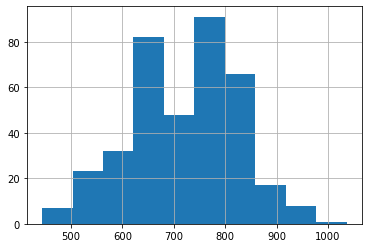

In [28]:
y_target.hist()

<AxesSubplot:>

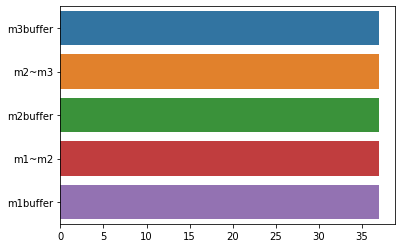

In [29]:
coef=pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values,y=coef_sort.index)

In [30]:
corr = df_dropped_2.corr(method = 'pearson')
corr

,m1buffer,m1~m2,m2buffer,m2~m3,m3buffer,cycletime_td
m1buffer,1.000000,-0.042869,-0.015861,-0.018235,0.112287,0.308091
m1~m2,-0.042869,1.000000,0.024754,0.016683,-0.014983,0.398793
m2buffer,-0.015861,0.024754,1.000000,-0.050094,-0.027174,0.461407
m2~m3,-0.018235,0.016683,-0.050094,1.000000,-0.014986,0.589185
m3buffer,0.112287,-0.014983,-0.027174,-0.014986,1.000000,0.396950
cycletime_td,0.308091,0.398793,0.461407,0.589185,0.396950,1.000000


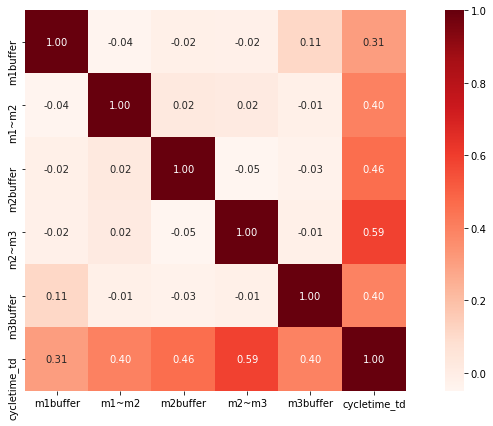

In [31]:
plt.subplots(figsize=(14,7))
df_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 10}, fmt = '.2f', square = True, cmap = 'Reds')

# Modeling
## LightGBM

In [32]:
import lightgbm as lgb

# LightGBM dataSet으로 변환
y_target = df_dropped_2['cycletime_td']
X_features = df_dropped_2.drop(['cycletime_td'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

train_LightGBM = lgb.Dataset(X_train, label = y_train) 
test_LightGBM = lgb.Dataset(X_test, label = y_test) 

In [33]:
#파라미터 세팅
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

In [34]:
#학습
model = lgb.train(params, train_LightGBM, 1000, test_LightGBM, verbose_eval=100, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 262, number of used features: 5
[LightGBM] [Info] Start training from score 719.099237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [35]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [36]:
mse = mean_squared_error(y_test, predict_test)
r2 = r2_score(y_test, predict_test)

In [37]:
print('Mean squared error: ', mse)
print('R2 score: ', r2)

Mean squared error:  147.80090295756438
R2 score:  0.9871059953112079


In [38]:
final_result_LightGBM = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predict_test)], axis = 1)
final_result_LightGBM.columns = ['label','predict']

<AxesSubplot:xlabel='label', ylabel='predict'>

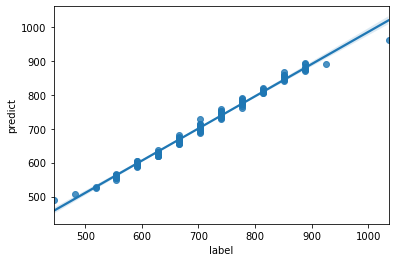

In [39]:
#fit 결과 확인
sns.regplot(x = 'label', y = 'predict', data = final_result_LightGBM)

## Ridge Regression

In [55]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

y_target = df_dropped_2['cycletime_td']
X_features = df_dropped_2.drop(['cycletime_td'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
pred=ridge_reg.predict(X_test)

print("훈련 세트의 정확도 : {:.2f}".format(ridge_reg.score(X_train,y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(ridge_reg.score(X_test,y_test)))
evaluate_regr(y_test,pred)

훈련 세트의 정확도 : 1.00
테스트 세트의 정확도 : 1.00
RMSLE: 0.0004550923, RMSE: 0.2900691245, MAE: 0.2286967204


113

## Lasso Regression

In [41]:
from sklearn.linear_model import Lasso

y_target = df_dropped_2['cycletime_td']
X_features = df_dropped_2.drop(['cycletime_td'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
pred=lasso_reg.predict(X_test)

print("훈련 세트의 정확도 : {:.2f}".format(lasso_reg.score(X_train, y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(lasso_reg.score(X_test, y_test)))
print("사용한 특성의 수 : {}".format(np.sum(lasso_reg.coef_ != 0)))
print("사용한 max_iter : {}".format(lasso_reg.n_iter_))
evaluate_regr(y_test,pred)

훈련 세트의 정확도 : 1.00
테스트 세트의 정확도 : 1.00
사용한 특성의 수 : 5
사용한 max_iter : 4
RMSLE: 0.0032270810, RMSE: 2.0609286070, MAE: 1.6248320681


## Elastic Net

In [42]:
from sklearn.linear_model import ElasticNet

y_target = df_dropped_2['cycletime_td']
X_features = df_dropped_2.drop(['cycletime_td'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=0)
elastic_net.fit(X_train, y_train)
pred=elastic_net.predict(X_test)

print("훈련 세트의 정확도 : {:.2f}".format(elastic_net.score(X_train, y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(elastic_net.score(X_test, y_test)))
evaluate_regr(y_test,pred)

훈련 세트의 정확도 : 1.00
테스트 세트의 정확도 : 1.00
RMSLE: 0.0058615410, RMSE: 3.7515823170, MAE: 2.9584563849


## Decision Tree

In [43]:
from sklearn.tree import DecisionTreeRegressor

y_target = df_dropped_2['cycletime_td']
X_features = df_dropped_2.drop(['cycletime_td'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

dt_reg = DecisionTreeRegressor(random_state = 0)
dt_reg.fit(X_train, y_train)
pred = dt_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE: 0.0630824922, RMSE: 44.8452600074, MAE: 33.3982300885


## Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor

y_target = df_dropped_2['cycletime_td']
X_features = df_dropped_2.drop(['cycletime_td'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

rf_reg = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=150)
rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)

featureImportance = rf_reg.feature_importances_

evaluate_regr(y_test,pred)

RMSLE: 0.0622425082, RMSE: 42.7665029432, MAE: 34.2324620165


## SVR

In [48]:
from sklearn.svm import SVR

y_target = df_dropped_2['cycletime_td']
X_features = df_dropped_2.drop(['cycletime_td'],axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

sv_reg = SVR(kernel = 'rbf')
sv_reg.fit(X_train, y_train)
pred = sv_reg.predict(X_test)
#pred = inverse_transform(y_pred)

evaluate_regr(y_test,pred)

RMSLE: 0.1299901426, RMSE: 89.7537389859, MAE: 72.1209292688


In [54]:
len(pred)

113